In [36]:
import os
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from palettable.colorbrewer.sequential import YlGn_8
from palettable.cartocolors.sequential import PurpOr_6
from palettable.colorbrewer.diverging import PuOr_7
from palettable.wesanderson import Mendl_4
from palettable.wesanderson import Margot3_4

from ideotype.data_process import read_data, agg_sims, fetch_sim_values, parse_mature
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import read_sim, fold
from ideotype import DATA_PATH
from ideotype.figures import plot_params_heatmap

In [2]:
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# set site as int for dataframe emrging purposes
df_all.site = df_all.site.astype(int)
df_stuck.site = df_stuck.site.astype(int)
df_wea.site = df_wea.site.astype(int)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

Text(0, 0.5, 'grain-fill length')

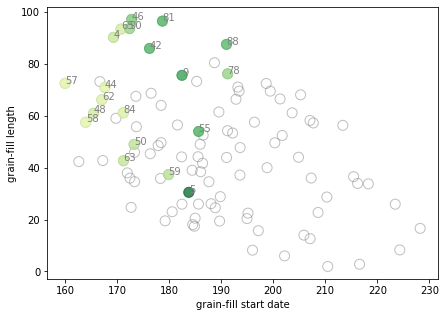

In [3]:
# fetch gf start dates & gf length
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']

# fetch top phenos
phenos = rank_top_phenos('present',20,1,1)[:20]

# visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

ax.scatter(gf_startdates, gf_lengths, alpha=0.5, s=100,
           facecolor='none', edgecolor='grey')

for pheno in phenos:
    ax.annotate(pheno, (gf_startdates[pheno], gf_lengths[pheno]), color='grey')

gfs = [gf_startdates[pheno] for pheno in phenos]
gfl = [gf_lengths[pheno] for pheno in phenos]

LAs = []
for pheno in phenos:
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)

ax.scatter(gfs, gfl, c=LAs, s=100, cmap=YlGn_8.mpl_colormap,
           vmin=500, vmax=8000, alpha=0.8)

ax.set_xlabel('grain-fill start date')
ax.set_ylabel('grain-fill length')

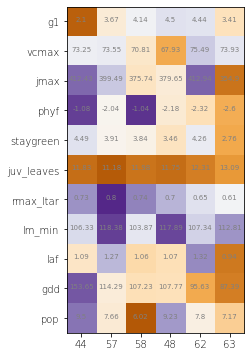

In [12]:
plot_params_heatmap(df_params, [44,57,58,48,62,63])

## Strategies

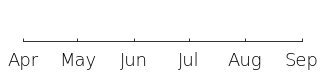

In [601]:
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(91,244)
ax.set_xticks([91, 121, 152, 182, 213, 244])
ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                   fontweight='light', fontsize=18)
ax.tick_params(axis='x', direction='in', pad=10)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_visible(False)

fig.subplots_adjust(bottom=0.4)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/phenostage_timeline.png', format='png', dpi=800)

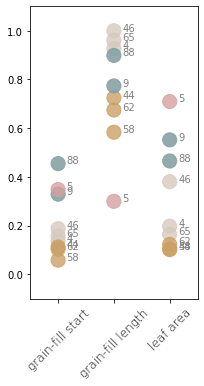

In [551]:
# phenos of interest
phenos = [4,65,46,  # slow aging
          44,58,62,  # stress averters
          88,9,  # high yielders
          5]  # compensators

# fetch emergent properties
gf_startdates = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['jday']
gf_lengths = df_phenology[df_phenology.pheno=='"grainFill"'].groupby(['cvar']).mean()['pheno_days']

LAs = []
for pheno in np.arange(100):
    LA = df_leaves.query(f'cvar=={pheno}').groupby('site').max()['LA'].mean()
    LAs.append(LA)
    
# visualization
fig = plt.figure(figsize=(3,7))
ax = fig.add_subplot(1,1,1)

colors = [Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2], Margot3_4.mpl_colors[2],
          Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1], Margot3_4.mpl_colors[1],
          Margot3_4.mpl_colors[0], Margot3_4.mpl_colors[0],
          Margot3_4.mpl_colors[3]]
alphas = [0.8, 0.8, 0.8,
          0.8, 0.8, 0.8, 
          0.9, 0.9,
          0.8]

gf_start_std = [(gf_startdates[pheno]-min(gf_startdates))/(max(gf_startdates)-min(gf_startdates)) for pheno in phenos]
gf_len_std = [(gf_lengths[pheno]-min(gf_lengths))/(max(gf_lengths)-min(gf_lengths)) for pheno in phenos]
la_std = [(LAs[pheno]-min(LAs))/(max(LAs)-min(LAs)) for pheno in phenos]

ax.scatter([1]*len(phenos), gf_start_std, c=colors, s=200, alpha=alphas)
ax.scatter([2]*len(phenos), gf_len_std, c=colors, s=200, alpha=alphas)
ax.scatter([3]*len(phenos), la_std, c=colors, s=200, alpha=alphas)

for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (1.15, gf_start_std[item]), color='grey')
for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (2.15, gf_len_std[item]), color='grey')
for item, pheno in enumerate(phenos):
    ax.annotate(pheno, (3.15, la_std[item]), color='grey')

ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['grain-fill start', 'grain-fill length', 'leaf area'], 
                   rotation=45, fontweight='light', fontsize=12)

fig.subplots_adjust(bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_strategies.png', format='png', dpi=800)

## Mechanisms

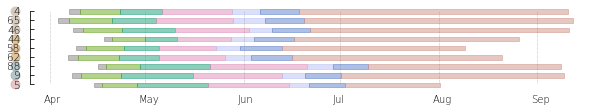

In [643]:
# identify targeted phenos
phenos = [4,65,46,44,58,62,88,9,5]
df_phenology_grouped = df_phenology.groupby(['cvar', 'pheno']).mean()
df_phenos = df_phenology_grouped.query(f'cvar in {phenos}')  

# set up phenostages
phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]
        
colors = ['grey', '#66a61e', '#1b9e77', 
          Mendl_4.mpl_colors[0],
          Mendl_4.mpl_colors[1],
          Mendl_4.mpl_colors[3],
          Mendl_4.mpl_colors[2]]

# visualization
fig = plt.figure(figsize=(10,1.5))

ax = fig.add_subplot(1,1,1)
ax.plot([85,270],[0,10], alpha=0)
ax.scatter(80, 8.8, color=Margot3_4.mpl_colors[2], s=80, alpha=1, clip_on=False)
ax.scatter(80, 7.8, color=Margot3_4.mpl_colors[2], s=80, alpha=1, clip_on=False)
ax.scatter(80, 6.8, color=Margot3_4.mpl_colors[2], s=80, alpha=1, clip_on=False)
ax.scatter(80, 5.8, color=Margot3_4.mpl_colors[1], s=80, alpha=0.6, clip_on=False)
ax.scatter(80, 4.8, color=Margot3_4.mpl_colors[1], s=80, alpha=0.6, clip_on=False)
ax.scatter(80, 3.8, color=Margot3_4.mpl_colors[1], s=80, alpha=0.6, clip_on=False)
ax.scatter(80, 2.8, color=Margot3_4.mpl_colors[0], s=80, alpha=0.6, clip_on=False)
ax.scatter(80, 1.8, color=Margot3_4.mpl_colors[0], s=80, alpha=0.6, clip_on=False)
ax.scatter(80, 0.8, color=Margot3_4.mpl_colors[3], s=80, alpha=0.6, clip_on=False)

ax.set_xlim(85,260)
ax.set_ylim(0.8,8.8)
ax.set_yticks(np.arange(0.8, len(phenos)))
ax.set_yticklabels(phenos[::-1], fontweight='light', fontsize=10.5)

jday_months = [91, 121, 152, 182, 213, 244, 274, 305, 335, 350]
for jday_month in jday_months:
    ax.axvline(x=jday_month, color='grey', linewidth=0.5, linestyle=':')

for phenostage, color in zip(phenostages, colors):
    df_phenostage1 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[0]}'].reset_index()
    df_phenostage1.index = df_phenostage1.cvar
    df_phenostage1 = df_phenostage1.reindex(phenos)

    df_phenostage2 = df_phenos[
        df_phenos.index.get_level_values('pheno') == f'{phenostage[1]}'].reset_index()
    df_phenostage2.index = df_phenostage2.cvar
    df_phenostage2 = df_phenostage2.reindex(phenos)

    cvars1 = np.arange(len(phenos))
    cvars2 = np.arange(len(phenos))

    jdays_start = np.empty(len(phenos))
    jdays_start[:] = np.nan
    jdays_start[cvars1] = list(df_phenostage1.jday.values)

    jdays_end = np.empty(len(phenos))
    jdays_end[:] = np.nan
    jdays_end[cvars2] = list(df_phenostage2.jday.values)

    jdays_len = [jend - jstart for jend, jstart in zip(jdays_end, jdays_start)]
    rankings = list(np.arange(len(phenos)))
    rankings.reverse()
    
    for item in np.arange(len(phenos)):
        rect = patches.Rectangle((jdays_start[item], len(phenos)-item-0.5), 
                                 jdays_len[item], 0.5,
                                 color=color, alpha=0.5, clip_on=False)
        ax.add_patch(rect)

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_visible(False)
ax.tick_params(axis='y', direction='in', pad=10)

xs = [91, 121, 152, 182, 213, 244]
months = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
for item in np.arange(len(months)):
    ax.text(xs[item]-2, -1.2, months[item], fontweight='light', clip_on=False)

fig.subplots_adjust(bottom=0.2)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_strategies.png', format='png', dpi=800)

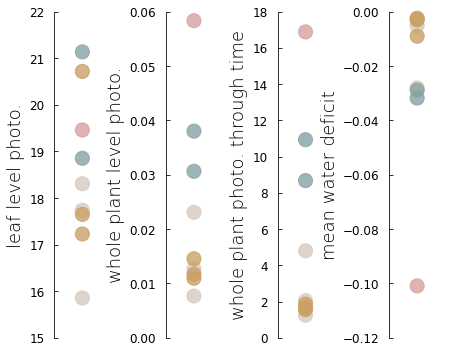

In [505]:
# set up plot parameters
phenostage = '"Emerged"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
ylims = [(15,22), (0, 0.06), (0,18), (-0.12, 0)]
ylabels = ['leaf level photo.',  'whole plant level photo.', 
           'whole plant photo. through time', 'mean water deficit']

# visualization
fig = plt.figure(figsize=(7,6))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    ax.scatter([1]*len(phenos), fetch_sim_values(df, phenostage, mechanism, phenos),
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.get_xaxis().set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', direction='in', pad=10)
    ax.set_ylim(ylims[count])
    ax.set_ylabel(ylabels[count], 
                  fontweight='light', fontsize=18)
    plt.yticks(fontsize=12)

fig.subplots_adjust(wspace=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_veg.png', format='png', dpi=800)

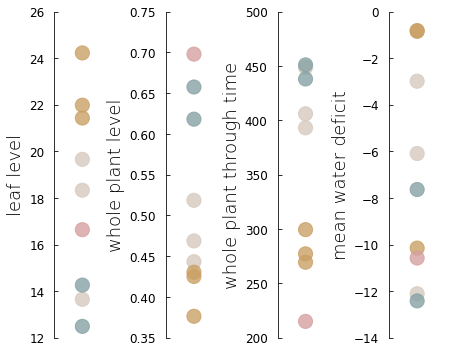

In [506]:
# set up plot parameters
phenostage = '"grainFill"'
dfs = [df_phys, df_phys, df_carbon, df_waterdeficit]
mechanisms = ['An', 'pn', 'pn_sum', 'water_deficit_mean']
ylabels = ['leaf level',  'whole plant level', 
           'whole plant through time', 'mean water deficit']
ylims = [(12,26), (0.35, 0.75), (200,500), (-14, 0)]

# visualization
fig = plt.figure(figsize=(7,6))

for count, (df, mechanism) in enumerate(zip(dfs, mechanisms)):
    ax = fig.add_subplot(1,4,count+1)
    ax.scatter([1]*len(phenos), fetch_sim_values(df, phenostage, mechanism, phenos),
               s=200, c=colors, alpha=alphas, clip_on=False)

    ax.get_xaxis().set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='y', direction='in', pad=10)
    ax.set_ylim(ylims[count])
    ax.set_ylabel(ylabels[count], 
                  fontweight='light', fontsize=18)
    plt.yticks(fontsize=12)

fig.subplots_adjust(wspace=1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_mechanisms_rep.png', format='png', dpi=800)